In [15]:

import numpy as np
import matplotlib.pyplot as plt
# Import required libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize
from PIL import Image
import numpy as np
from numpy import asarray

from qiskit import transpile
from qiskit.visualization import array_to_latex
from qiskit_aer import Aer

# Use AerSimulator for the latest version
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit



In [19]:

def amplitude_encode(img_data):
    
    # Calculate the RMS value
    rms_32_rgb = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))
    
    # Create normalized image
    image_norm = []
    for arr in img_data:
        for ele in arr:
            image_norm.append(ele / rms_32_rgb)
        
    # Return the normalized image as a numpy array
    return np.array(image_norm)
def horverencode(im_r):
    h_norm_im = amplitude_encode(im_r)   
    v_norm_im = amplitude_encode(im_r.T)
    return h_norm_im,v_norm_im
    
def hed(h_norm_image_32_rgb,v_norm_image_32_rgb,Amp_permutation_unitary_32_rgb,total_q_32_rgb):
    h_norm_image_32_rgb /= np.linalg.norm(h_norm_image_32_rgb)
    v_norm_image_32_rgb /= np.linalg.norm(v_norm_image_32_rgb)
    qc_h_32_rgb = QuantumCircuit(total_q_32_rgb)
    qc_h_32_rgb.initialize(h_norm_image_32_rgb, range(1, total_q_32_rgb))
    qc_h_32_rgb.h(0)
    qc_h_32_rgb.unitary(Amp_permutation_unitary_32_rgb, range(total_q_32_rgb))
    qc_h_32_rgb.h(0)   
    
    # Create the circuit for vertical scan
    qc_v_32_rgb = QuantumCircuit(total_q_32_rgb)
    qc_v_32_rgb.initialize(v_norm_image_32_rgb, range(1, total_q_32_rgb))
    qc_v_32_rgb.h(0)
    qc_v_32_rgb.unitary(Amp_permutation_unitary_32_rgb, range(total_q_32_rgb))
    qc_v_32_rgb.h(0)    
    # Combine both circuits into a single list
    circ_list_32_rgb = [qc_h_32_rgb, qc_v_32_rgb]
    return circ_list_32_rgb
def simu(circ_list_32_rgb,data_q_32_rgb):
    # Define the simulator backend
    simulator = Aer.get_backend('statevector_simulator')
    
    # Assuming `circ_list_32_rgb`, `qc_h_32_rgb`, and `qc_v_32_rgb` are your quantum circuits
    # Transpile the circuits for the simulator (this optimizes them for the simulator backend)
    transpiled_circuits = [transpile(circ, simulator) for circ in circ_list_32_rgb]
    
    # Run the transpiled circuits on the simulator
    results = simulator.run(transpiled_circuits).result()
    
    # Retrieve the statevectors for horizontal and vertical scans
    state_vector_h_32_rgb = results.get_statevector(circ_list_32_rgb[0])
    state_vector_v_32_rgb = results.get_statevector(circ_list_32_rgb[1])
    
    # Print the size of the statevectors
    # print("Size is", state_vector_h_32_rgb.size)
    
    # # Visualize the statevectors
    # print('Horizontal scan statevector:')
    # display(array_to_latex(state_vector_h_32_rgb, max_size=128))
    
    # print('Vertical scan statevector:')
    # display(array_to_latex(state_vector_v_32_rgb, max_size=128))
    threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)

    # Selecting odd states from the raw statevector and
    # reshaping column vector of size 64 to an 8x8 matrix
    h_edge_scan_img_32_rgb = np.abs(np.array([1 if threshold(state_vector_h_32_rgb[2*(i)+1].real) else 0 for i in range(2**data_q_32_rgb)])).reshape(32, 32)
    v_edge_scan_img_32_rgb= np.abs(np.array([1 if threshold(state_vector_v_32_rgb[2*(i)+1].real) else 0 for i in range(2**data_q_32_rgb)])).reshape(32, 32).T

    return h_edge_scan_img_32_rgb,v_edge_scan_img_32_rgb
    
def start(img,n_qubits):
    img=asarray(img)
    im_r = img[:, :, 0]
    im_g = img[:, :, 1]
    im_b = img[:, :, 2]
    
    h_norm_im_r,v_norm_im_r = horverencode(im_r)
    h_norm_im_g,v_norm_im_g = horverencode(im_g)
    h_norm_im_b,v_norm_im_b = horverencode(im_b)
    data_q_32_rgb = n_qubits
    ancillary_q_32_rgb = 1
    total_q_32_rgb = data_q_32_rgb + ancillary_q_32_rgb

    # Initialize the amplitude permutation unitary
    Amp_permutation_unitary_32_rgb = np.identity(2**total_q_32_rgb)
    print(Amp_permutation_unitary_32_rgb)
    Amp_permutation_unitary_32_rgb=np.roll(Amp_permutation_unitary_32_rgb,1,axis=1)

    circ_list_r = hed(h_norm_im_r,v_norm_im_r,Amp_permutation_unitary_32_rgb,total_q_32_rgb)
    circ_list_g = hed(h_norm_im_g,v_norm_im_g,Amp_permutation_unitary_32_rgb,total_q_32_rgb)
    circ_list_b = hed(h_norm_im_b,v_norm_im_b,Amp_permutation_unitary_32_rgb,total_q_32_rgb)
    
    h_edge_r , v_edge_r = simu(circ_list_r,data_q_32_rgb)
    h_edge_g , v_edge_g = simu(circ_list_g,data_q_32_rgb)
    h_edge_b , v_edge_b = simu(circ_list_b,data_q_32_rgb)
    edge_scan_image_32_rgb = h_edge_r+h_edge_g+h_edge_b+v_edge_r+v_edge_g+v_edge_b
    
    # print(img)
    # plt.imshow(img)
    # plt.title("Original")
    # plt.show()
    


    # plt.imshow(edge_scan_image_32_rgb)
    
    # plt.title("Afterprocessing")
    #plt.show()
    return edge_scan_image_32_rgb
    

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


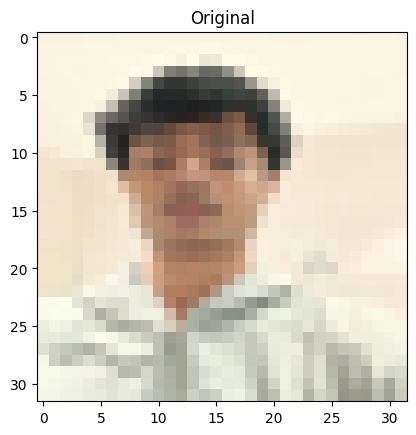

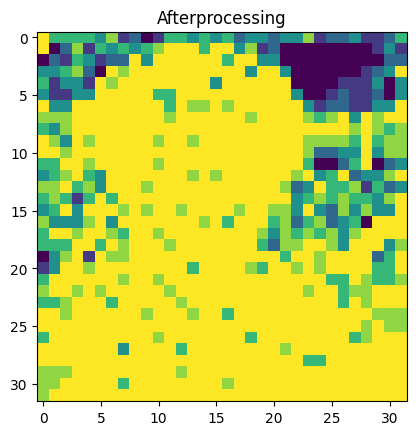

In [20]:
filename = 'proc2.jpg'

n_qubits = 10
n_pixels_per_side = 2 ** (n_qubits // 2)
img = Image.open(filename)


# Resize the image
img = img.resize((n_pixels_per_side, n_pixels_per_side))
processed = start(img,n_qubits)

plt.imshow(img)
plt.title("Original")
plt.show()
plt.imshow(processed)    
plt.title("Afterprocessing")
plt.show()


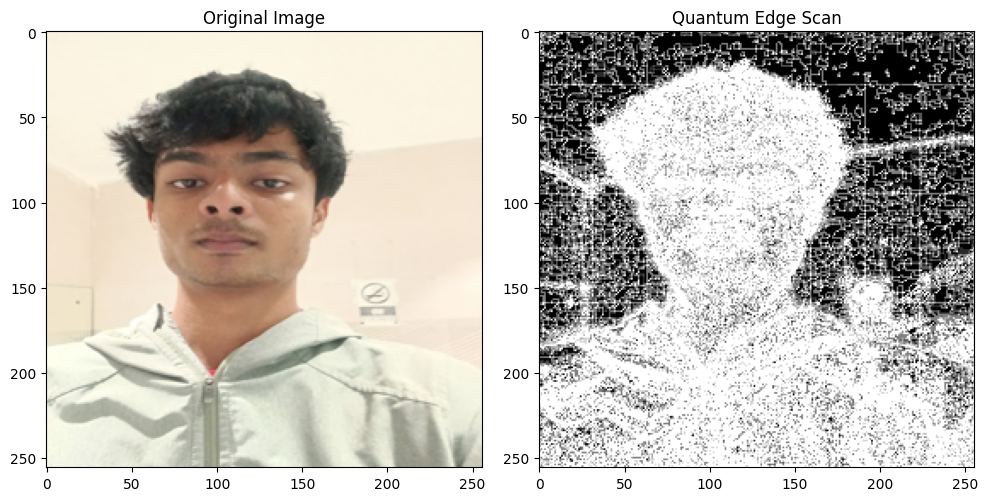

In [ ]:
def process_image_chunks(filename, chunk_size=32, n_qubits=10):
    # Open and resize the image to ensure it's a multiple of chunk size
   
    img = Image.open(filename)
    img = img.resize((256, 256))
    img_array = np.array(img)
    
    # Initialize the final edge scan image
    final_edge_scan = np.zeros((256, 256))
    
    # Process each 32x32 chunk
    for i in range(0, 256, chunk_size):
        for j in range(0, 256, chunk_size):
            # Extract the chunk
            chunk = img_array[i:i+chunk_size, j:j+chunk_size]
            
            # Process each color channel
            im_r = chunk[:, :, 0]
            im_g = chunk[:, :, 1]
            im_b = chunk[:, :, 2]
            
            # Perform quantum edge detection on each channel
            h_norm_im_r, v_norm_im_r = horverencode(im_r)
            h_norm_im_g, v_norm_im_g = horverencode(im_g)
            h_norm_im_b, v_norm_im_b = horverencode(im_b)
            
            data_q_32_rgb = n_qubits
            ancillary_q_32_rgb = 1
            total_q_32_rgb = data_q_32_rgb + ancillary_q_32_rgb

            # Initialize the amplitude permutation unitary
            Amp_permutation_unitary_32_rgb = np.identity(2**total_q_32_rgb)
            Amp_permutation_unitary_32_rgb = np.roll(Amp_permutation_unitary_32_rgb, 1, axis=1)

            # Process circuits for each color channel
            circ_list_r = hed(h_norm_im_r, v_norm_im_r, Amp_permutation_unitary_32_rgb, total_q_32_rgb)
            circ_list_g = hed(h_norm_im_g, v_norm_im_g, Amp_permutation_unitary_32_rgb, total_q_32_rgb)
            circ_list_b = hed(h_norm_im_b, v_norm_im_b, Amp_permutation_unitary_32_rgb, total_q_32_rgb)
            
            # Simulate and get edge scans
            h_edge_r, v_edge_r = simu(circ_list_r, data_q_32_rgb)
            h_edge_g, v_edge_g = simu(circ_list_g, data_q_32_rgb)
            h_edge_b, v_edge_b = simu(circ_list_b, data_q_32_rgb)
            
            # Combine edge scans for the chunk
            chunk_edge_scan = h_edge_r + h_edge_g + h_edge_b + v_edge_r + v_edge_g + v_edge_b
            
            # Place the chunk in the final image
            final_edge_scan[i:i+chunk_size, j:j+chunk_size] = chunk_edge_scan
    
    # Visualize and return the final edge scan
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title('Original Image')
    plt.imshow(img)
    plt.subplot(1,2,2)
    plt.title('Quantum Edge Scan')
    plt.imshow(final_edge_scan, cmap='gray')
    plt.tight_layout()
    plt.show()
    
    return final_edge_scan

# Usage
result = process_image_chunks('proc2.jpg')


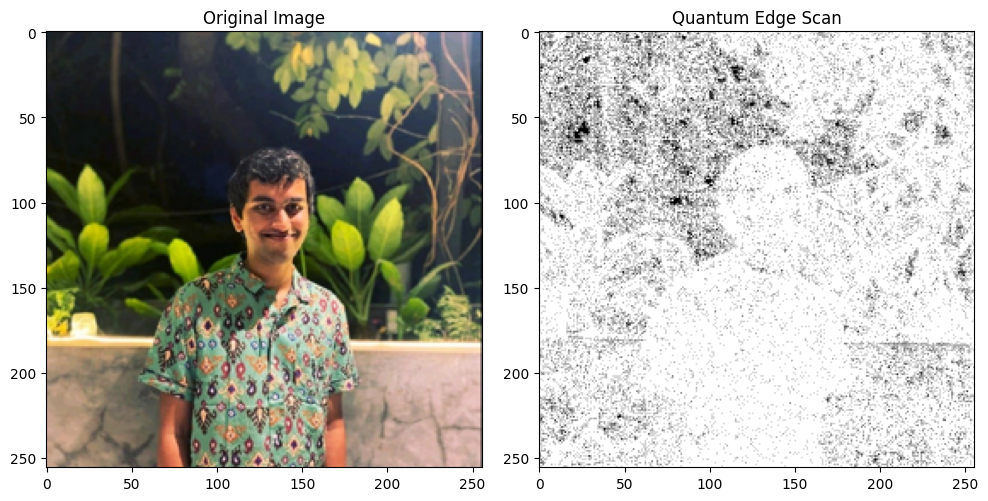

In [23]:

# Usage
result = process_image_chunks('proc.jpg')
